# This code calculates three features of the recording: ampltiude traces of summed frequencies, pitch, entropy, and periodicity.

The screen resolution in inches is: 15.12x9.82
Segment 1: 🎵 Song detected.
Segment 2: 🎵 Song detected.
Segment 3: 🎵 Song detected.


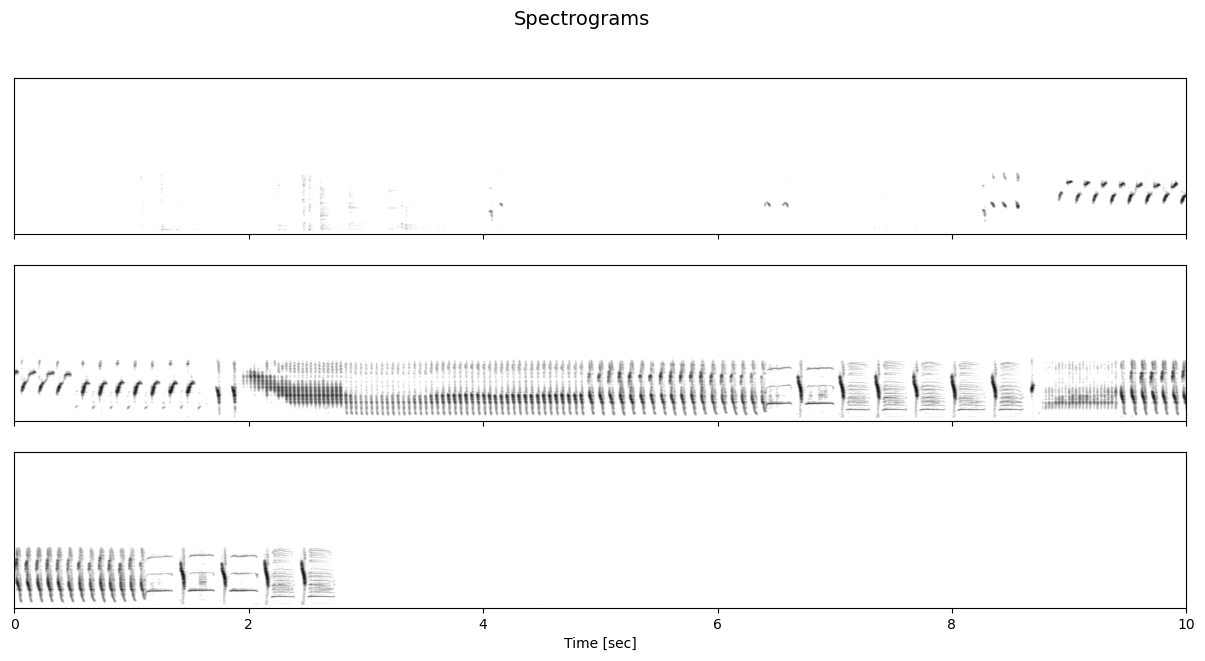

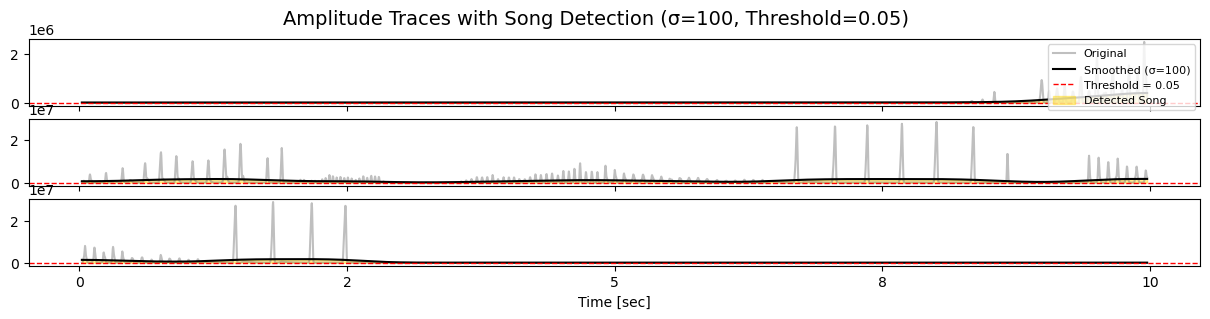

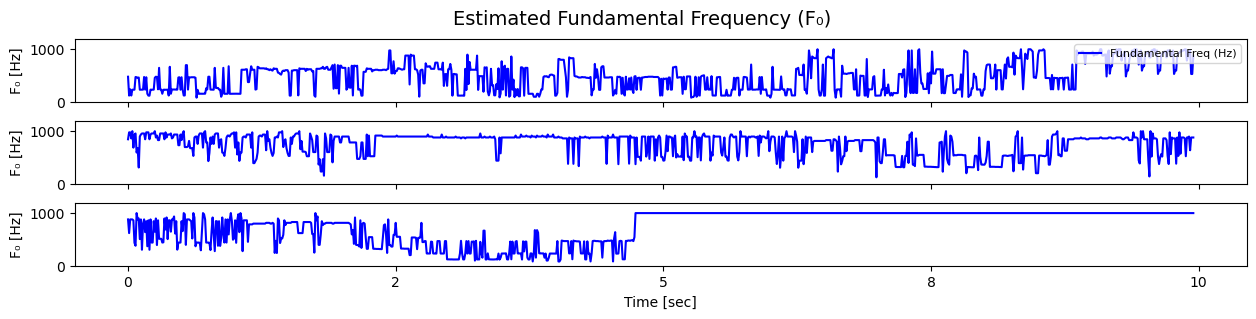

: 

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def estimate_fundamental_frequency(segment, samplerate, window_size_ms=40, hop_size_ms=10, fmin=80, fmax=1000):
    window_size = int(window_size_ms * samplerate / 1000)
    hop_size = int(hop_size_ms * samplerate / 1000)
    max_lag = int(samplerate / fmin)
    min_lag = int(samplerate / fmax)

    f0_values = []
    times = []

    for start in range(0, len(segment) - window_size, hop_size):
        window = segment[start:start + window_size]
        window -= np.mean(window)

        corr = np.correlate(window, window, mode='full')[window.size-1:]
        corr[:min_lag] = 0
        peak_index = np.argmax(corr[min_lag:max_lag]) + min_lag
        peak_value = corr[peak_index]

        if peak_value > 0:
            f0 = samplerate / peak_index
        else:
            f0 = np.nan

        f0_values.append(f0)
        times.append(start / samplerate)

    return np.array(times), np.array(f0_values)

def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000, sigma=100, threshold=0.05):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_f0 = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_f0 = [axs_f0]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Amplitude trace ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            smoothed_trace = gaussian_filter1d(amplitude_trace, sigma=sigma)

            axs_sum[i].plot(t, amplitude_trace, color='gray', alpha=0.5, label='Original')
            axs_sum[i].plot(t, smoothed_trace, color='black', label=f'Smoothed (σ={sigma})')
            axs_sum[i].axhline(threshold, color='red', linestyle='--', linewidth=1, label=f'Threshold = {threshold}')

            is_song = smoothed_trace > threshold
            axs_sum[i].fill_between(t, smoothed_trace, threshold, where=is_song, interpolate=True,
                                    color='gold', alpha=0.4, label='Detected Song' if i == 0 else None)

            # === Fundamental Frequency (F₀) ===
            f0_times, f0_values = estimate_fundamental_frequency(segment_data, samplerate)
            axs_f0[i].plot(f0_times, f0_values, color='blue', label='Fundamental Freq (Hz)')
            axs_f0[i].set_ylim(0, 1200)
            axs_f0[i].set_ylabel('F₀ [Hz]')

            if np.any(is_song):
                print(f"Segment {i + 1}: 🎵 Song detected.")
            else:
                print(f"Segment {i + 1}: ⚪ No song detected.")

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                axs_f0[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
                axs_f0[i].set_xticks(tick_positions)
                axs_f0[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])
                axs_f0[i].set_xticks([])

            if i == 0:
                axs_sum[i].legend(loc='upper right', fontsize=8)
                axs_f0[i].legend(loc='upper right', fontsize=8)

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle(f'Amplitude Traces with Song Detection (σ={sigma}, Threshold={threshold})', fontsize=14)
        fig3.suptitle('Estimated Fundamental Frequency (F₀)', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, sigma=100, threshold=0.05)
